In [40]:
# Import Modules.
import nnabla as nn
import nnabla.functions as F
import nnabla.parametric_functions as PF
from nnabla import solvers as S
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.interpolation'] = 'bicubic'
%matplotlib inline

In [41]:
# Get MNIST dataset. copied from nnabla/examples/vision/mnist/mnist_data.py.

# Copyright (c) 2017 Sony Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

'''
Provide data iterator for MNIST examples.
'''
import numpy
import struct
import zlib

from nnabla.logger import logger
from nnabla.utils.data_iterator import data_iterator
from nnabla.utils.data_source import DataSource
from nnabla.utils.data_source_loader import download


class MnistDataSource(DataSource):
    '''
    Get data directly from MNIST dataset from Internet(yann.lecun.com).
    '''

    def _get_data(self, position):
        image = self._images[self._indexes[position]]
        label = self._labels[self._indexes[position]]
        return (image, label)

    def __init__(self, train=True, shuffle=False, rng=None):
        super(MnistDataSource, self).__init__(shuffle=shuffle)
        self._train = train
        if self._train:
            image_uri = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
            label_uri = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
        else:
            image_uri = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
            label_uri = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'

        logger.info('Getting label data from {}.'.format(label_uri))
        # With python3 we can write this logic as following, but with
        # python2, gzip.object does not support file-like object and
        # urllib.request does not support 'with statement'.
        #
        #   with request.urlopen(label_uri) as r, gzip.open(r) as f:
        #       _, size = struct.unpack('>II', f.read(8))
        #       self._labels = numpy.frombuffer(f.read(), numpy.uint8).reshape(-1, 1)
        #
        r = download(label_uri)
        data = zlib.decompress(r.read(), zlib.MAX_WBITS | 32)
        _, size = struct.unpack('>II', data[0:8])
        self._labels = numpy.frombuffer(data[8:], numpy.uint8).reshape(-1, 1)
        r.close()
        logger.info('Getting label data done.')

        logger.info('Getting image data from {}.'.format(image_uri))
        r = download(image_uri)
        data = zlib.decompress(r.read(), zlib.MAX_WBITS | 32)
        _, size, height, width = struct.unpack('>IIII', data[0:16])
        self._images = numpy.frombuffer(data[16:], numpy.uint8).reshape(
            size, 1, height, width)
        r.close()
        logger.info('Getting image data done.')

        self._size = self._labels.size
        self._variables = ('x', 'y')
        if rng is None:
            rng = numpy.random.RandomState(313)
        self.rng = rng
        self.reset()

    def reset(self):
        if self._shuffle:
            self._indexes = self.rng.permutation(self._size)
        else:
            self._indexes = numpy.arange(self._size)
        super(MnistDataSource, self).reset()

    @property
    def images(self):
        """Get copy of whole data with a shape of (N, 1, H, W)."""
        return self._images.copy()

    @property
    def labels(self):
        """Get copy of whole label with a shape of (N, 1)."""
        return self._labels.copy()


def data_iterator_mnist(batch_size,
                        train=True,
                        rng=None,
                        shuffle=True,
                        with_memory_cache=False,
                        with_parallel=False,
                        with_file_cache=False):
    '''
    Provide DataIterator with :py:class:`MnistDataSource`
    with_memory_cache, with_parallel and with_file_cache option's default value is all False,
    because :py:class:`MnistDataSource` is able to store all data into memory.
    For example,
    .. code-block:: python
        with data_iterator_mnist(True, batch_size) as di:
            for data in di:
                SOME CODE TO USE data.
    '''
    return data_iterator(MnistDataSource(train=train, shuffle=shuffle, rng=rng),
                         batch_size,
                         with_memory_cache,
                         with_parallel,
                         with_file_cache)

In [42]:
# get new dataset and converted.
def next_data(data):
    dst = data.next()[0].astype('float32') / 255.
    return dst.reshape((len(dst), np.prod(dst.shape[1:])))

In [43]:
# build model.
def prediction(x, dim):
    with nn.parameter_scope("enc"):
        enc = F.relu(PF.affine(x, dim))
    with nn.parameter_scope("dec"):
        dec = F.sigmoid(PF.affine(enc, 784))
    return dec

In [44]:
# build graph.
batch_size = 256
encord_dim = 32
nn.clear_parameters()

image = nn.Variable(shape=(batch_size, 784)) # for train.
pred = prediction(image, encord_dim)
loss = F.mean(F.binary_cross_entropy(pred, image))

vimage = nn.Variable(shape=(batch_size, 784)) # for test.
vpred = prediction(vimage, encord_dim)

In [45]:
# setup solver.
solver =  S.Adam()
solver.set_parameters(nn.get_parameters())

In [46]:
# training.
data = data_iterator_mnist(batch_size, True) # data_iterator_mnist: from nnabla/examples/vision/mnist/mnist_data.py.
vdata = data_iterator_mnist(batch_size, False) # data_iterator_mnist: from nnabla/examples/vision/mnist/mnist_data.py.

for i in range(1000):
    data_for_train = next_data(data)
    image.d = data_for_train
    loss.forward()
        
    solver.zero_grad()
    loss.backward()
    solver.weight_decay(1e-3)
    solver.update()
    
    if i%100 == 0:
        print i, loss.d

2017-07-17 20:30:55,585 [nnabla][INFO]: DataSource with shuffle(True)
2017-07-17 20:30:55,586 [nnabla][INFO]: Getting label data from http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz.
2017-07-17 20:30:55,589 [nnabla][INFO]: > C:\Users\0000143088/nnabla_data\train-labels-idx1-ubyte.gz in cache.
2017-07-17 20:30:55,592 [nnabla][INFO]: > If you have any issue when using this file, 
2017-07-17 20:30:55,595 [nnabla][INFO]: > manually remove the file and try download again.
2017-07-17 20:30:55,605 [nnabla][INFO]: Getting label data done.
2017-07-17 20:30:55,607 [nnabla][INFO]: Getting image data from http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz.
2017-07-17 20:30:55,608 [nnabla][INFO]: > C:\Users\0000143088/nnabla_data\train-images-idx3-ubyte.gz in cache.
2017-07-17 20:30:55,611 [nnabla][INFO]: > If you have any issue when using this file, 
2017-07-17 20:30:55,614 [nnabla][INFO]: > manually remove the file and try download again.
2017-07-17 20:30:55,982 [nnabla][INFO

0 0.694398522377
100 0.26072576642
200 0.226647943258
300 0.208155110478
400 0.202261790633
500 0.201069891453
600 0.199144765735
700 0.192777201533
800 0.196126803756
900 0.194584667683


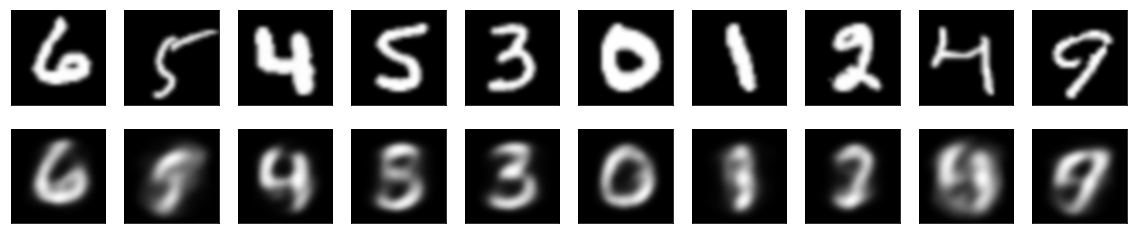

In [47]:
# validation.
data_for_test = next_data(vdata)
vimage.d  = data_for_test
vpred.forward()
output = vpred.d

# show decorded image.
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    src = data_for_test[i].reshape(28, 28)
    plt.imshow(src)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    dst = output[i].reshape(28, 28)
    plt.imshow(dst)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()